In [1]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from catboost import Pool, CatBoostRegressor
pd.set_option('display.max_columns', None)
print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
      ' | device num:', os.environ['CUDA_VISIBLE_DEVICES'])
from catboost.utils import get_gpu_device_count
print('available GPU devices catboost:', get_gpu_device_count())

available GPU devices: 1  | device num: 0
available GPU devices catboost: 1


In [2]:
DATA_DIR = './data'
MODELS_DIR = './models'
MODEL_VER = 'v0'
BACKWARD_LAGS = 60
CUT_DATE = '2014-04-01'
VAL_DATE = '2016-04-01'
END_DATE = '2016-04-24'
print(datetime.strptime(END_DATE, '%Y-%m-%d'))
#-----|CUT_DATE|---train---|VAL_DATE|--val--|END_DATE|--forecast +28 days-->

2016-04-24 00:00:00


In [3]:
CALENDAR_DTYPES = {
    'date':             'str',
    'wm_yr_wk':         'int16', 
    'weekday':          'object',
    'wday':             'int16', 
    'month':            'int16', 
    'year':             'int16', 
    'd':                'object',
    'event_name_1':     'object',
    'event_type_1':     'object',
    'event_name_2':     'object',
    'event_type_2':     'object',
    'snap_CA':          'int16', 
    'snap_TX':          'int16', 
    'snap_WI':          'int16'
}
PARSE_DATES = ['date']
SPRICES_DTYPES = {
    'store_id':    'object', 
    'item_id':     'object', 
    'wm_yr_wk':    'int16',  
    'sell_price':  'float32'
}

In [4]:
def get_df(is_train=True, backward_lags=None):
    strain = pd.read_csv('{}/sales_train_validation.csv'.format(DATA_DIR))
    print('read train:', strain.shape)
    cat_cols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    last_day = int(strain.columns[-1].replace('d_', ''))
    print('last day is:', last_day)
    if not is_train:
        for day in range(last_day + 1, last_day + 29):
            strain['d_{}'.format(day)] = np.nan
    strain = pd.melt(
        strain,
        id_vars = cat_cols,
        value_vars = [col for col in strain.columns if col.startswith('d_')],
        var_name = 'd',
        value_name = 'sales'
    )
    print('melted train:', strain.shape)
    calendar = pd.read_csv('{}/calendar.csv'.format(DATA_DIR), dtype=CALENDAR_DTYPES, parse_dates=PARSE_DATES)
    print('read calendar:', calendar.shape)
    strain = strain.merge(calendar, on='d', copy=False)
    print('calendar merge done')
    sprices = pd.read_csv('{}/sell_prices.csv'.format(DATA_DIR), dtype=SPRICES_DTYPES)
    print('read prices:', sprices.shape)
    strain = strain.merge(
        sprices, 
        on=['store_id', 'item_id', 'wm_yr_wk'], 
        copy=False
    )
    print('prices merge done')
    if not is_train:
        strain = strain.loc[
            strain['date'] >= (datetime.strptime(END_DATE, '%Y-%m-%d') - timedelta(days=backward_lags))
        ]
    else:
        strain = strain.loc[strain['date'] >= CUT_DATE]
    print('date cut train:', strain.shape)
    print('cut train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    return strain

In [5]:
def make_features(strain):
    print('in dataframe:', strain.shape)
    lags = [7, 28]
    windows= [7, 28]
    wnd_feats = [
        'id', 
        'item_id', 
        'dept_id', 
        'store_id', 
        'cat_id', 
        'state_id'
    ]
    lag_cols = ['lag_{}'.format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        strain[lag_col] = strain[['id', 'sales']].groupby('id')['sales'].shift(lag)
    print('lag sales done')
    for wnd_feat in wnd_feats:
        for wnd in windows:
            for lag_col in lag_cols:
                wnd_col = '{}_{}_rmean_{}'.format(lag_col, wnd_feat, wnd)
                strain[wnd_col] = strain[[wnd_feat, lag_col]].groupby(wnd_feat)[lag_col].transform(
                    lambda x: x.rolling(wnd).mean()
                )
        print('rolling mean sales for feature done:', wnd_feat)
    date_features = {
        'week_num': 'weekofyear',
        'quarter': 'quarter',
        'mday': 'day'
    }
    for date_feat_name, date_feat_func in date_features.items():
        strain[date_feat_name] = getattr(strain['date'].dt, date_feat_func).astype('int16')
    print('date features done')
    strain['d'] = strain['d'].apply(lambda x: int(x.replace('d_', '')))  
    print('out dataframe:', strain.shape)
    return strain

In [6]:
%%time
strain = get_df(is_train=True, backward_lags=None)

read train: (30490, 1919)
last day is: 1913
melted train: (58327370, 8)
read calendar: (1969, 14)
calendar merge done
read prices: (6841121, 4)
prices merge done
date cut train: (22425491, 22)
cut train date: 2014-04-01 00:00:00
end train date: 2016-04-24 00:00:00
CPU times: user 37.1 s, sys: 6.77 s, total: 43.9 s
Wall time: 43.9 s


In [7]:
%%time
strain = make_features(strain)

in dataframe: (22425491, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
rolling mean sales for feature done: dept_id
rolling mean sales for feature done: store_id
rolling mean sales for feature done: cat_id
rolling mean sales for feature done: state_id
date features done
out dataframe: (22425491, 51)
CPU times: user 2min 6s, sys: 17.2 s, total: 2min 23s
Wall time: 2min 23s


from 2014-04-01 00:00:00 to 2016-04-24 00:00:00


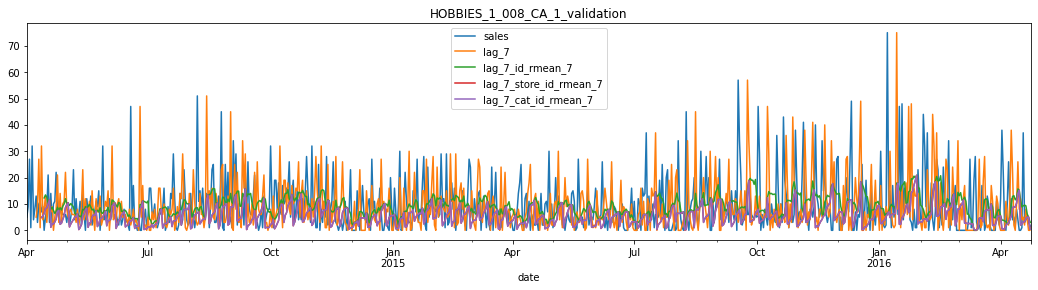

In [8]:
id_name = 'HOBBIES_1_008_CA_1_validation'
id_sales = strain.loc[strain['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales['lag_7'].plot(label='lag_7')
id_sales['lag_7_id_rmean_7'].plot(label='lag_7_id_rmean_7')
id_sales['lag_7_store_id_rmean_7'].plot(label='lag_7_store_id_rmean_7')
id_sales['lag_7_cat_id_rmean_7'].plot(label='lag_7_cat_id_rmean_7')
plt.title(id_name)
plt.legend()
plt.show()

In [9]:
drop_cols = ['id', 'sales', 'date', 'wm_yr_wk', 'weekday']
train_cols = strain.columns[~strain.columns.isin(drop_cols)]
cat_cols = ['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'year', 
            'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
strain[cat_cols] = strain[cat_cols].fillna(0)

In [10]:
%%time
if False:
    X_train = strain[strain['date'] <= VAL_DATE][train_cols]
    y_train = strain[strain['date'] <= VAL_DATE]['sales']
    X_val = strain[strain['date'] > VAL_DATE][train_cols]
    y_val = strain[strain['date'] > VAL_DATE]['sales']
else:
    val_size = int(strain.shape[0] * .15)
    val_idxs = np.random.choice(strain.index.values, val_size, replace=False)
    train_idxs = np.setdiff1d(strain.index.values, val_idxs)
    X_train = strain.loc[train_idxs][train_cols]
    y_train = strain.loc[train_idxs]['sales']
    X_val = strain.loc[val_idxs][train_cols]
    y_val = strain.loc[val_idxs]['sales']
print('train shapes:', X_train.shape, len(y_train))
print('val shapes:', X_val.shape, len(y_val))
train_pool = Pool(
    X_train, 
    y_train,
    cat_features=cat_cols
)
val_pool = Pool(
    X_val, 
    y_val,
    cat_features=cat_cols
)

train shapes: (19061668, 46) 19061668
val shapes: (3363823, 46) 3363823
CPU times: user 1min 36s, sys: 3.28 s, total: 1min 40s
Wall time: 1min 26s


In [11]:
model = CatBoostRegressor(
    iterations=1000,
    task_type='GPU',
    verbose=0,
    loss_function='RMSE'
)
model.fit(
    train_pool,
    eval_set = val_pool,
    plot=True   
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [12]:
model.save_model('{}/model_{}.cbm'.format(MODELS_DIR, MODEL_VER))

In [13]:
model = CatBoostRegressor().load_model('{}/model_{}.cbm'.format(MODELS_DIR, MODEL_VER))

In [14]:
feat_importances = sorted(
    [(f, v) for f, v in zip(train_cols, model.get_feature_importance())],
    key=lambda x: x[1],
    reverse=True
)

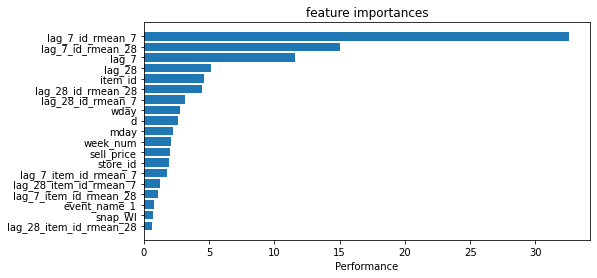

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
labels, values = [x[0] for x in feat_importances if x[1] > .5], [x[1] for x in feat_importances if x[1] > .5]
y_pos = np.arange(len(labels))
ax.barh(y_pos, values)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Performance')
ax.set_title('feature importances')
plt.show()

In [16]:
preds = model.predict(strain[strain['date'] >= VAL_DATE][train_cols])
print(len(preds))

731760


In [17]:
spred = strain[strain['date'] >= VAL_DATE].copy()
spred.loc[:, 'sales'] = preds

In [18]:
strain['id'].unique()

array(['HOBBIES_1_001_CA_1_validation', 'HOBBIES_1_002_CA_1_validation',
       'HOBBIES_1_003_CA_1_validation', ...,
       'HOUSEHOLD_1_400_CA_4_validation',
       'HOUSEHOLD_1_386_WI_1_validation',
       'HOUSEHOLD_1_020_WI_2_validation'], dtype=object)

id to draw: HOUSEHOLD_1_038_CA_4_validation
from 2014-04-01 00:00:00 to 2016-04-24 00:00:00


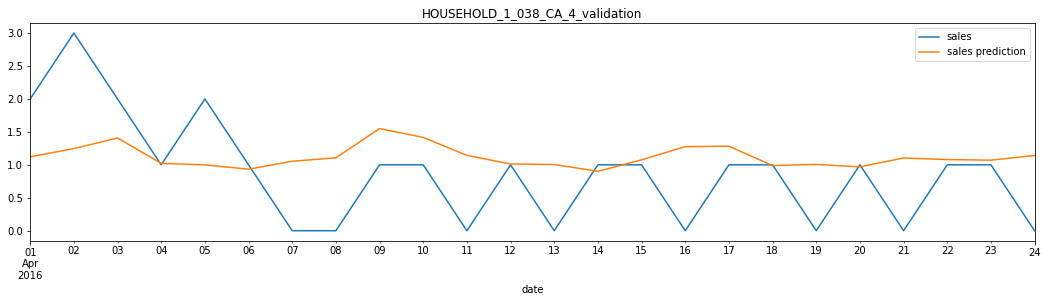

In [25]:
id_name = np.random.choice(strain['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[(strain['id'] == id_name) & (strain['date'] >= VAL_DATE)].set_index('date')
id_sales_pred = spred.loc[spred['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [26]:
%%time
spred = get_df(is_train=False, backward_lags=BACKWARD_LAGS)
for pred_day in range(1, 29):
    pred_date = datetime.strptime(END_DATE, '%Y-%m-%d') + timedelta(days=pred_day)
    pred_date_back = pred_date - timedelta(days=BACKWARD_LAGS + 1)
    print('-' * 70)
    print('forecast day forward:', pred_day, '| forecast date:', pred_date) 
    spred_data = spred[(spred['date'] >= pred_date_back) & (spred['date'] <= pred_date)].copy()
    spred_data = make_features(spred_data)
    spred_data = spred_data.loc[spred['date'] == pred_date, train_cols]
    spred_data[cat_cols] = spred_data[cat_cols].fillna(0)
    spred.loc[spred['date'] == pred_date, 'sales'] = model.predict(spred_data)

read train: (30490, 1919)
last day is: 1913
melted train: (59181090, 8)
read calendar: (1969, 14)
calendar merge done
read prices: (6841121, 4)
prices merge done
date cut train: (2713610, 22)
cut train date: 2016-02-24 00:00:00
end train date: 2016-05-22 00:00:00
----------------------------------------------------------------------
forecast day forward: 1 | forecast date: 2016-04-25 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
rolling mean sales for feature done: dept_id
rolling mean sales for feature done: store_id
rolling mean sales for feature done: cat_id
rolling mean sales for feature done: state_id
date features done
out dataframe: (1890380, 51)
----------------------------------------------------------------------
forecast day forward: 2 | forecast date: 2016-04-26 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature d

in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
rolling mean sales for feature done: dept_id
rolling mean sales for feature done: store_id
rolling mean sales for feature done: cat_id
rolling mean sales for feature done: state_id
date features done
out dataframe: (1890380, 51)
----------------------------------------------------------------------
forecast day forward: 18 | forecast date: 2016-05-12 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
rolling mean sales for feature done: dept_id
rolling mean sales for feature done: store_id
rolling mean sales for feature done: cat_id
rolling mean sales for feature done: state_id
date features done
out dataframe: (1890380, 51)
----------------------------------------------------------------------
forecast day forward: 19 | forecast date: 2016-05-13 00:00:00
in dataframe: (18903

id to draw: FOODS_2_263_TX_1_validation
from 2014-04-01 00:00:00 to 2016-05-22 00:00:00


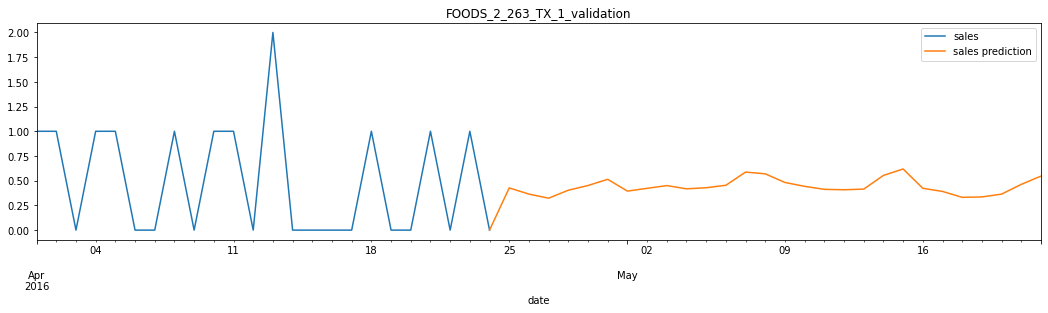

In [41]:
id_name = np.random.choice(strain['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[(strain['id'] == id_name) & (strain['date'] >= VAL_DATE)].set_index('date')
id_sales_pred = spred.loc[(spred['id'] == id_name) & (spred['date'] >= END_DATE)].set_index('date')
print('from', strain['date'].min(), 'to', spred['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [42]:
spred_subm = spred.loc[spred['date'] > END_DATE, ['id', 'd', 'sales']].copy()
last_d = int(spred.loc[spred['date'] == END_DATE, 'd'].unique()[0].replace('d_', ''))
print('last d num:', last_d)
spred_subm['d'] = spred_subm['d'].apply(lambda x: 'F{}'.format(int(x.replace('d_', '')) - last_d))
spred_subm['sales'].where(spred_subm['sales'] < 0, 0)
spred_subm.head()

last d num: 1913


,id,d,sales
45966979,HOBBIES_1_001_CA_1_validation,F1,0.810160
45966980,HOBBIES_1_001_CA_1_validation,F2,0.747929
45966981,HOBBIES_1_001_CA_1_validation,F3,0.652575
45966982,HOBBIES_1_001_CA_1_validation,F4,0.648437
45966983,HOBBIES_1_001_CA_1_validation,F5,0.750531


In [43]:
f_cols = ['F{}'.format(x) for x in range(1, 29)]
spred_subm = spred_subm.set_index(['id', 'd']).unstack()['sales'][f_cols].reset_index()
spred_subm.fillna(0, inplace=True)
spred_subm.where(spred_subm[f_cols] < 0, 0)
spred_subm.sort_values('id', inplace=True)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.head()

d,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.904331,0.832297,0.805421,0.811716,1.005596,1.098405,1.036007,0.930057,0.954050,1.037298,0.962574,0.989558,1.173477,1.255425,0.920921,0.860747,0.858425,0.827365,0.863444,1.198636,1.190713,0.856306,0.800790,0.777673,0.752179,0.837589,1.099958,1.136951
1,FOODS_1_001_CA_2_validation,0.956861,0.897997,0.777548,0.955518,1.011087,1.584835,1.819880,0.965647,0.941082,0.877698,0.765555,0.983753,1.393593,1.356182,0.999651,0.863666,0.892127,0.886416,0.898782,1.409867,1.810733,1.026247,0.999363,1.000114,1.047959,1.066424,1.497314,1.464106
2,FOODS_1_001_CA_3_validation,1.008492,0.994126,0.826371,0.846938,0.790457,1.066977,0.818560,0.855855,0.916470,0.838460,0.838269,0.812663,1.198870,1.272132,0.902052,0.842855,0.845811,0.842835,0.835863,1.118499,1.700036,0.912098,0.915381,0.796306,0.765257,0.803882,1.094465,0.943821
3,FOODS_1_001_CA_4_validation,0.379997,0.349810,0.306176,0.323708,0.393152,0.377710,0.305135,0.291565,0.309146,0.339529,0.430184,0.422520,0.446462,0.447700,0.379753,0.358872,0.319450,0.357432,0.406527,0.427997,0.527030,0.385031,0.356898,0.384377,0.375002,0.413147,0.449292,0.522770
4,FOODS_1_001_TX_1_validation,0.340863,0.287596,0.234993,0.305110,0.280565,0.239761,0.116528,0.163119,0.338763,0.275812,0.307782,0.372555,0.474053,0.493608,0.418011,0.385118,0.375226,0.397540,0.377255,0.471559,0.593161,0.330118,0.328446,0.344476,0.341875,0.349389,0.399927,0.516954


In [44]:
spred_subm_eval = spred_subm.copy()
spred_subm_eval["id"] = spred_subm_eval["id"].str.replace("validation", "evaluation")
spred_subm = pd.concat([spred_subm, spred_subm_eval], axis=0, sort=False)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.to_csv('submission.csv', index=False)
print('submission saved:', spred_subm.shape)

submission saved: (60980, 29)
